# Head

In [1]:
# NumCosmo
from numcosmo_py import Nc, Ncm
from numcosmo_py.ccl.nc_ccl import create_nc_obj, CCLParams, dsigmaM_dlnM
from numcosmo_py.ccl.comparison import compare_ccl_nc_func

# CCL
import pyccl as ccl

import sys
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline

---


# Comparison Notebook: CCL - Background module

---


### Starting NumCosmo

First, we have to iniciate the NumCosmo configuration, and redirect it's outputs to this notebook. We do this with the following lines:

In [2]:
Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

### Defining initial quantities

Before creating the comparison functions, we must create all the necessary global variables and atribute their initial values.

In [3]:
Omega_c = 0.25
Omega_b = 0.05
Omega_k = 0.0
h = 0.7
A_s = 2.1e-9
n_s = 0.96
Neff = 0.0
sigma8 = 0.9
mu_0 = 0.1
sigma_0 = 0.1

Omega_v_vals = np.array([0.7, 0.7, 0.7, 0.65, 0.75])
w0_vals = np.array([-1.0, -0.9, -0.9, -0.9, -0.9])
wa_vals = np.array([0.0, 0.0, 0.1, 0.1, 0.1])

mnu = [[0.04, 0.0, 0.0], [0.05, 0.01, 0.0], [0.05, 0.0, 0.0], [0.03, 0.02, 0.0]]
Neff_mnu = 3.0

### Table of variables

Simple explanation of the values defined above.


| Var. Name |    Quantity     |
|   :----:  |     :----:      |
|  Omega_c  | Cold Dark Matter Density |
|  Omega_b  | Baryonic Matter Density  |
|  Omega_v  | Dark Energy Density |
|  Omega_k  | Curvature Density |
|     h     |    Hubble Constant  (dimensionless)  |
|    A_s    | Power spectrum normalization |
|    n_s    | Adiabatic scalar spectral index |
|    Neff   | Effective Nº of massless neutrinos present |
|   sigma8  | Standard deviation of the matter density contrast*|
|    mu_0   | parameter of the mu-Sigma modified gravity model|
|  sigma_0  | parameter of the mu-Sigma modified gravity model|
|    w0     | parameter of the DE equation of state|
|    wa     | parameter of the DE equation of state|
|    mnu    | Total mass in eV of the massive neutrinos |


\* at an 8 Mpc/h scale

---

### 1) Distance

We define a function to compare the distances estimated by the CCL cosmology and the NumCosmo cosmology. We'll start by defining the curvature density, setting up CCL to high precision, and creating a CCL cosmology with the global parameters. With the external function "create_nc_obj()", the CCL cosmology object will create a NumCosmo cosmology object using the same parameters. Then, the function will compare the cosmological distances implemented in CCL and NumCosmo.


In [4]:
def compare_distances(z, Omega_v, w0, wa):
    """
    Compare distances calculated by pyccl with the distances in the benchmark
    file.
    This test is only valid when radiation is explicitly set to 0.
    """
    # Set Omega_K in a consistent way
    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ccl_cosmo = ccl.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        Neff=Neff,
        h=h,
        A_s=A_s,
        n_s=n_s,
        Omega_k=Omega_k,
        w0=w0,
        wa=wa,
        transfer_function="eisenstein_hu",
    )
    # CCLParams.set_high_prec_params()

    cosmology = create_nc_obj(ccl_cosmo)
    cosmo = cosmology.cosmo
    dist = cosmology.dist

    a = 1.0 / (1.0 + z)

    ccl_E = ccl.h_over_h0(ccl_cosmo, a)
    nc_E = [cosmo.E(z_i) for z_i in z]

    compare_ccl_nc_func(z, ccl_E, nc_E, x_name="z", y_name="E")

    ccl_chi = ccl.comoving_radial_distance(ccl_cosmo, a)
    RH_Mpc = cosmo.RH_Mpc()
    # R = (3*10**8)/72
    nc_chi = np.array(dist.comoving_vector(cosmo, z)) * RH_Mpc

    compare_ccl_nc_func(z, ccl_chi, nc_chi, x_name="z", y_name="D_c")

    ccl_ct = ccl.comoving_angular_distance(ccl_cosmo, a)
    nc_ct = np.array(dist.transverse_vector(cosmo, z)) * RH_Mpc

    compare_ccl_nc_func(z, ccl_ct, nc_ct, x_name="z", y_name="D_t")

    ccl_cad = ccl.angular_diameter_distance(ccl_cosmo, a)
    nc_cad = np.array(dist.angular_diameter_vector(cosmo, z)) * RH_Mpc

    compare_ccl_nc_func(z, ccl_cad, nc_cad, x_name="z", y_name="D_a")

    ccl_ld = ccl.luminosity_distance(ccl_cosmo, a)
    nc_ld = np.array(dist.luminosity_vector(cosmo, z)) * RH_Mpc

    compare_ccl_nc_func(z, ccl_ld, nc_ld, x_name="z", y_name="D_l")

    ccl_dm = ccl.distance_modulus(ccl_cosmo, a)
    nc_dm = [dist.dmodulus(cosmo, z_i) + 5 * math.log10(RH_Mpc) for z_i in z]

    compare_ccl_nc_func(z, ccl_dm, nc_dm, x_name="z", y_name="D_m")

    t_H = (
        ccl.physical_constants.MPC_TO_METER
        / 1e14
        / ccl.physical_constants.YEAR
        / ccl_cosmo["h"]
    )
    ccl_lt = ccl.lookback_time(ccl_cosmo, a)
    nc_lt = [dist.lookback_time(cosmo, z_i) * t_H for z_i in z]

    compare_ccl_nc_func(z, ccl_lt, nc_lt, x_name="z", y_name="t_L")

    ccl_cve = a**2 * ccl.comoving_volume_element(ccl_cosmo, a)
    nc_cve = [dist.comoving_volume_element(cosmo, z_i) * RH_Mpc**3 for z_i in z]

    compare_ccl_nc_func(z, ccl_cve, nc_cve, x_name="z", y_name=r"dV/dzd\Omega")

Now we use the function to different values of dark energy and different parameters of it's equation of state.

--------------------------------------------------------------------------------
[E         ]: rel diff min: 4.28923563e-12	rel diff max: 2.26246168e-05
[D_c       ]: rel diff min: 6.52554411e-09	rel diff max: 9.17286102e-04
[D_t       ]: rel diff min: 6.52554411e-09	rel diff max: 9.17286102e-04
[D_a       ]: rel diff min: 6.52554399e-09	rel diff max: 9.17286102e-04
[D_l       ]: rel diff min: 6.52554399e-09	rel diff max: 9.17286102e-04
[D_m       ]: rel diff min: 2.89543056e-10	rel diff max: 4.48316474e-05
[t_L       ]: rel diff min: 1.99840144e-14	rel diff max: 1.76605477e-07
[dV/dzd\Omega]: rel diff min: 2.39022705e-07	rel diff max: 1.83549341e-03
--------------------------------------------------------------------------------



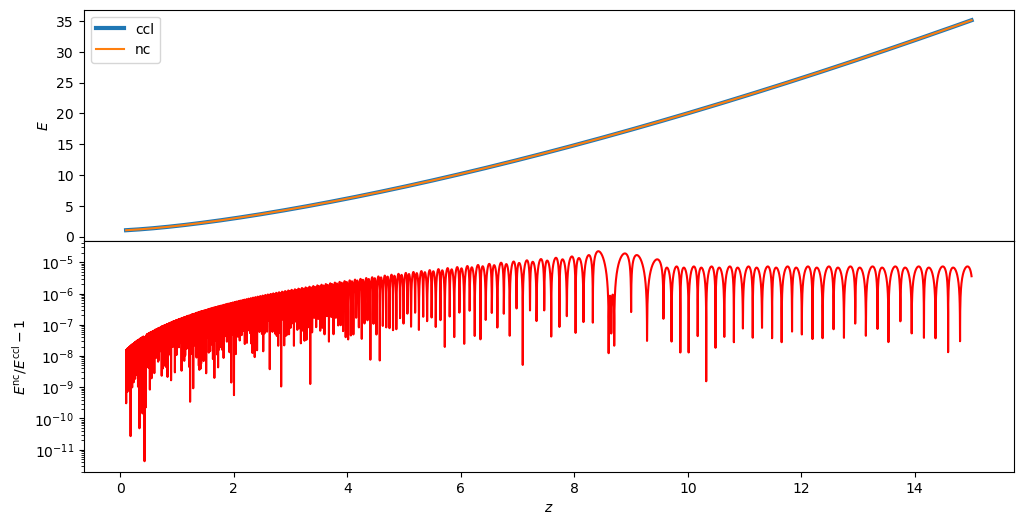

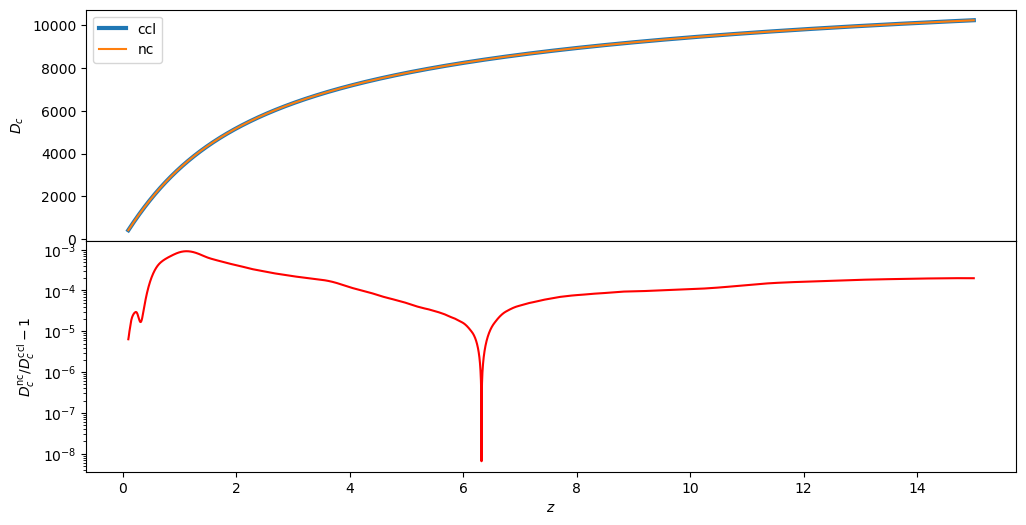

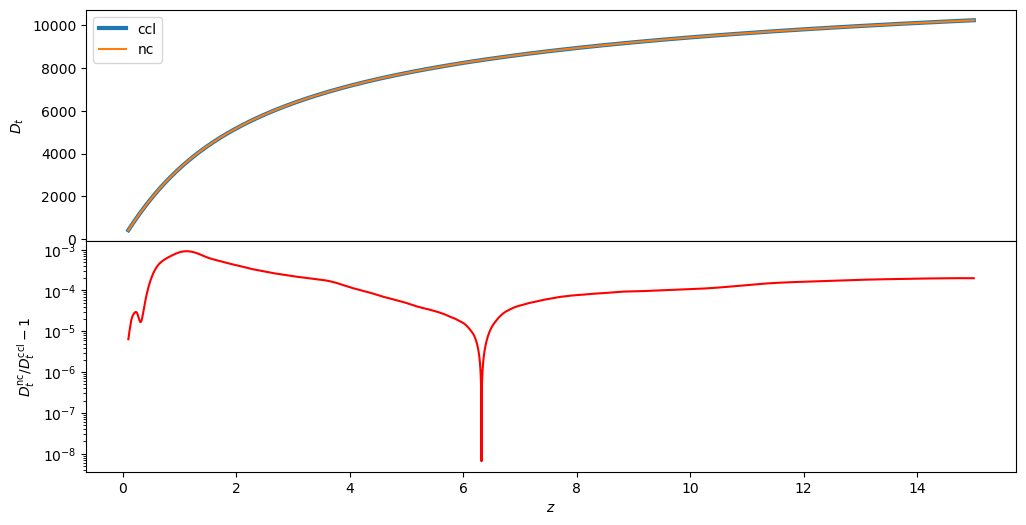

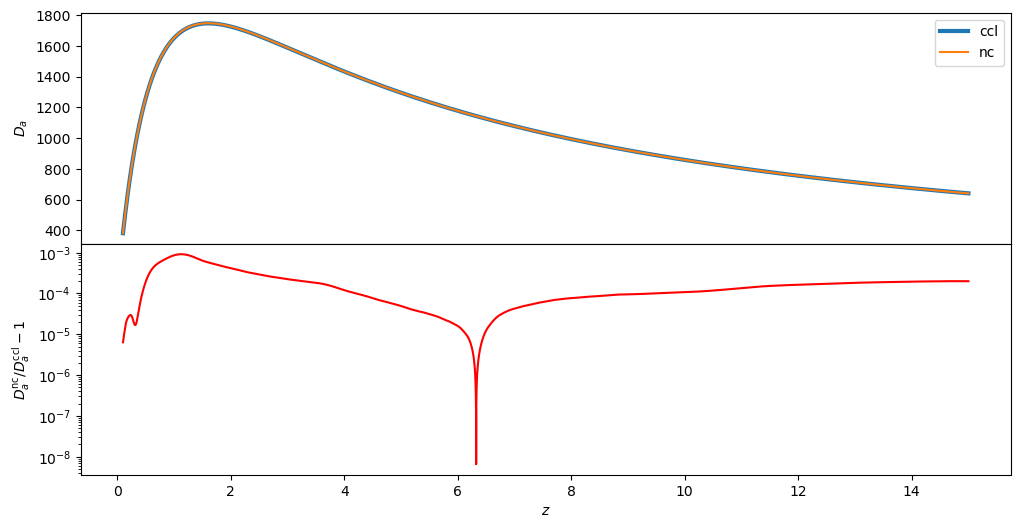

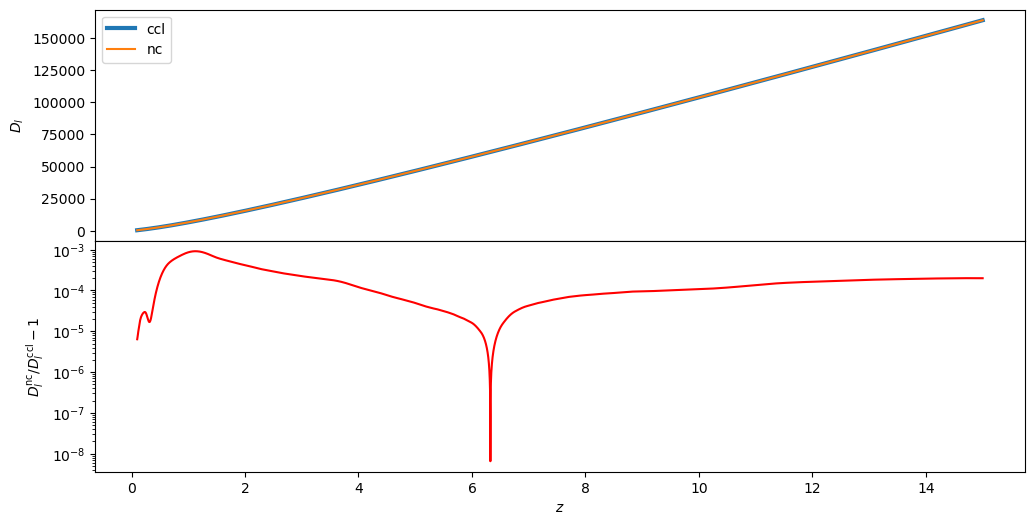

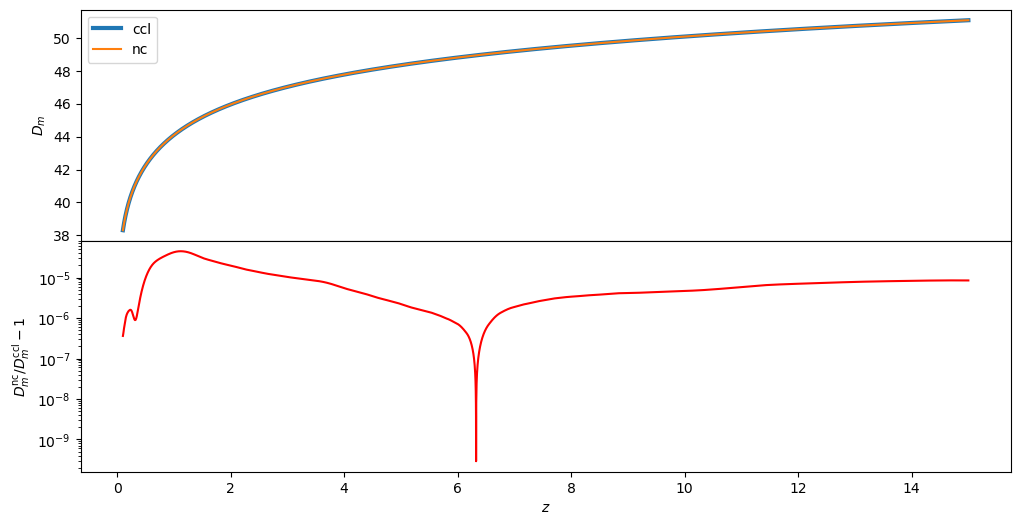

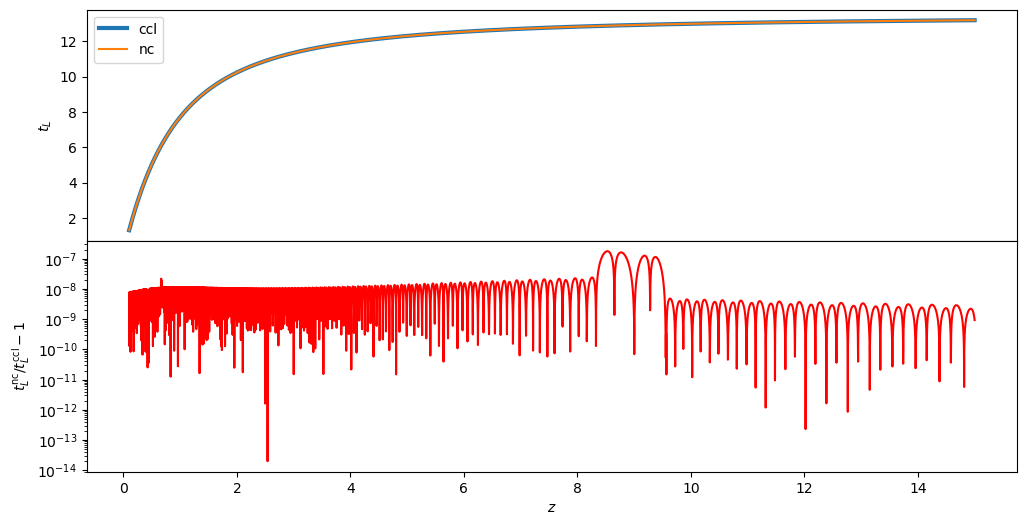

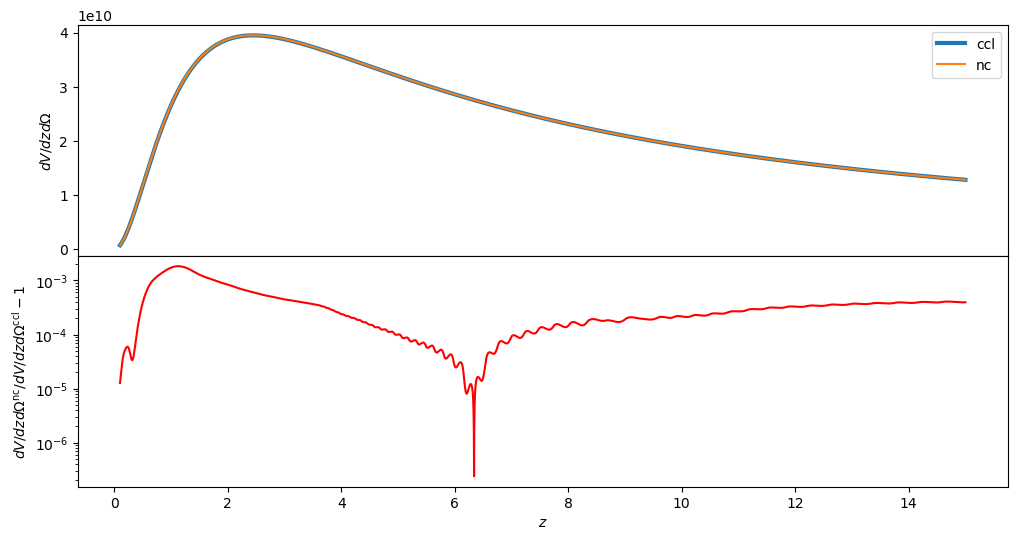


--------------------------------------------------------------------------------
[E         ]: rel diff min: 1.42369450e-11	rel diff max: 2.25935179e-05
[D_c       ]: rel diff min: 2.28222847e-07	rel diff max: 9.71660370e-04
[D_t       ]: rel diff min: 2.28222847e-07	rel diff max: 9.71660370e-04
[D_a       ]: rel diff min: 2.28222847e-07	rel diff max: 9.71660370e-04
[D_l       ]: rel diff min: 2.28222847e-07	rel diff max: 9.71660370e-04
[D_m       ]: rel diff min: 1.12571384e-08	rel diff max: 4.41620282e-05
[t_L       ]: rel diff min: 2.14239737e-12	rel diff max: 1.78003560e-07
[dV/dzd\Omega]: rel diff min: 4.14708803e-07	rel diff max: 1.94908721e-03
--------------------------------------------------------------------------------



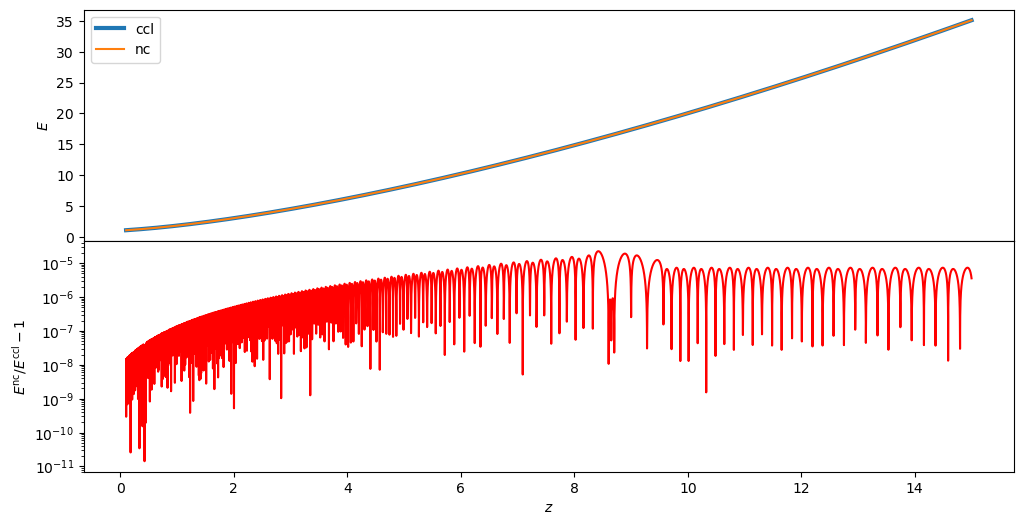

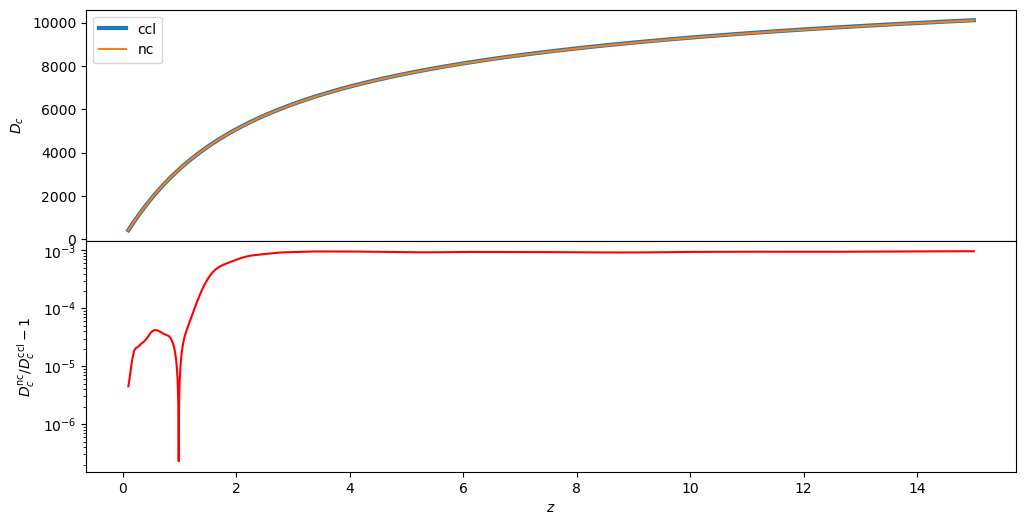

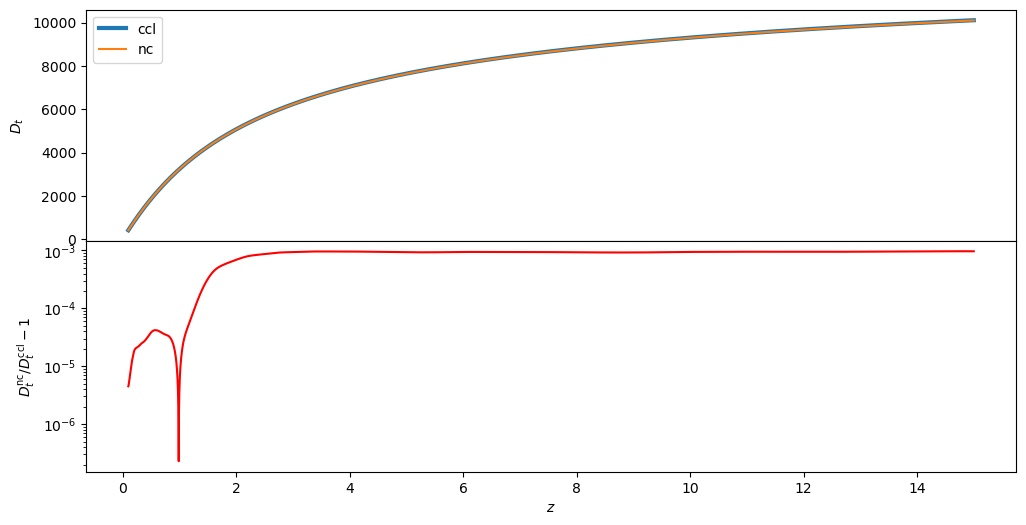

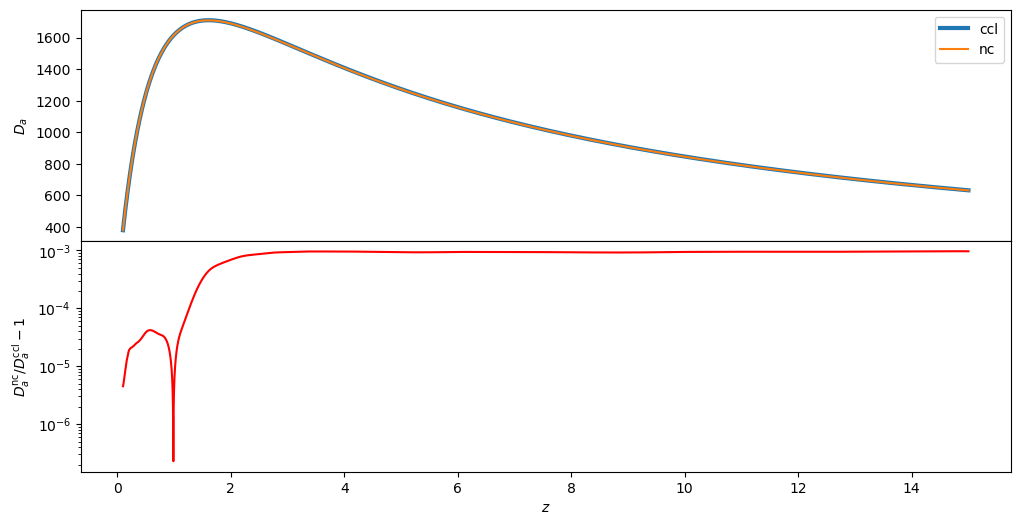

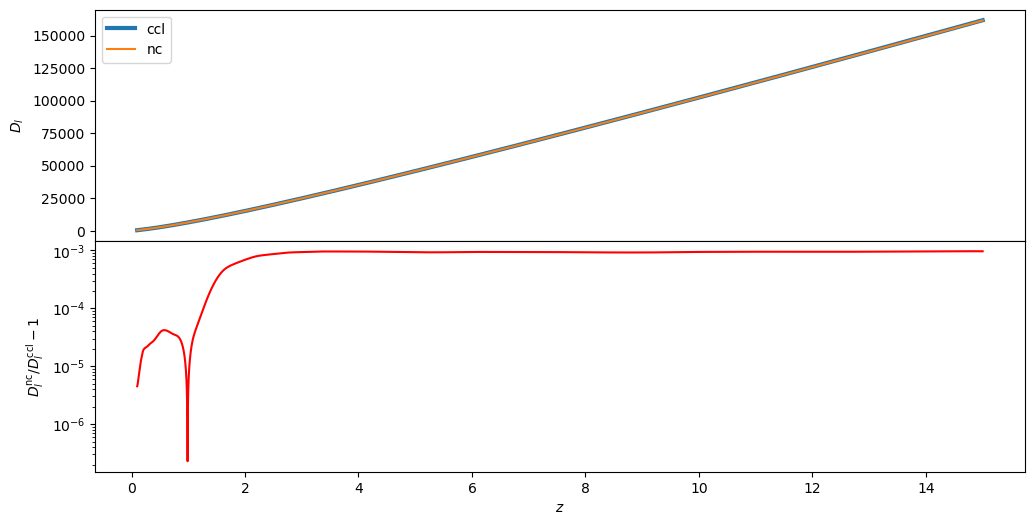

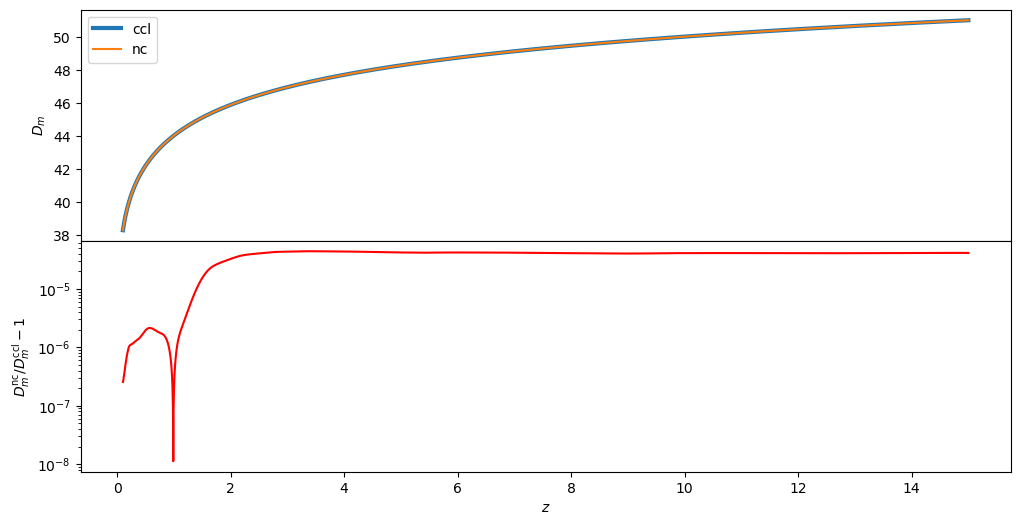

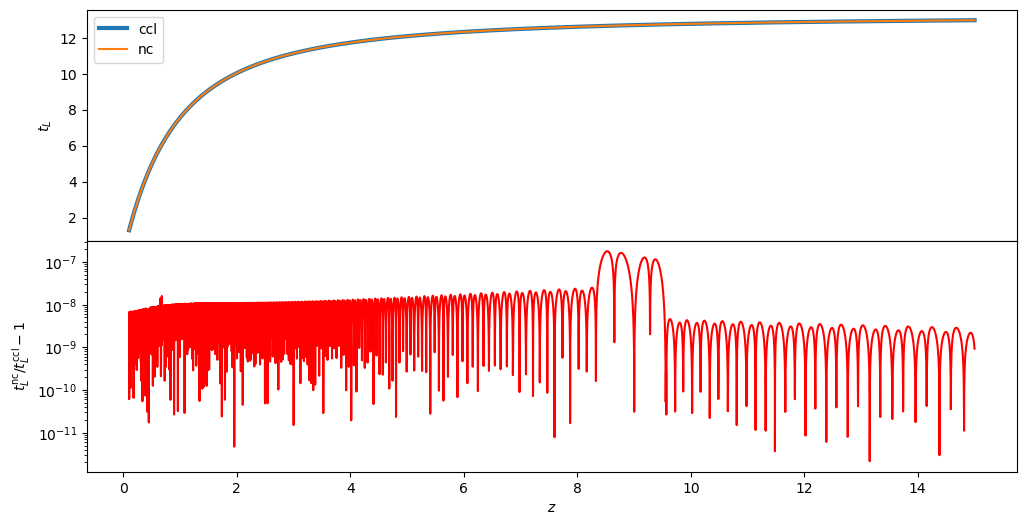

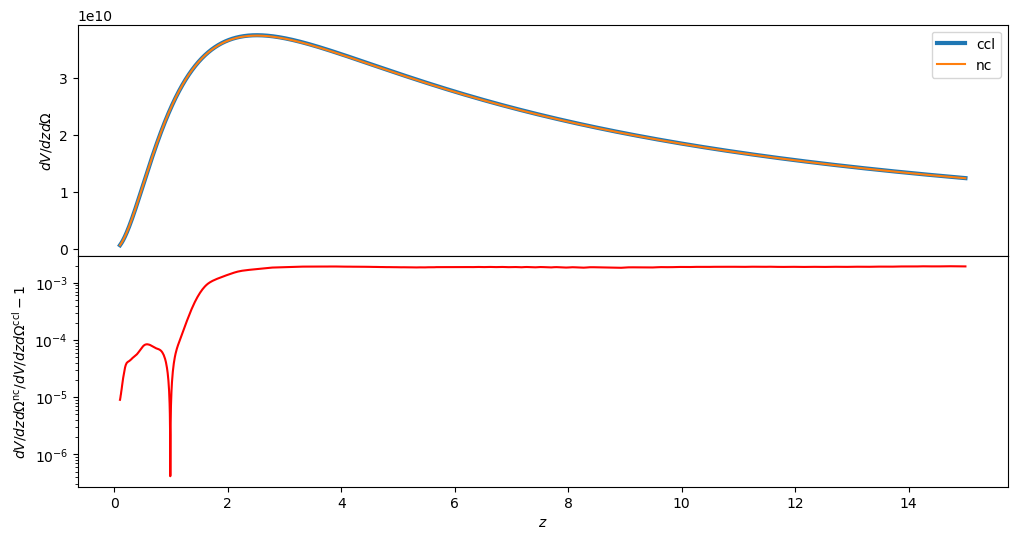


--------------------------------------------------------------------------------
[E         ]: rel diff min: 7.68185515e-12	rel diff max: 2.25599769e-05
[D_c       ]: rel diff min: 1.21170140e-07	rel diff max: 8.37770650e-04
[D_t       ]: rel diff min: 1.21170140e-07	rel diff max: 8.37770650e-04
[D_a       ]: rel diff min: 1.21170140e-07	rel diff max: 8.37770650e-04
[D_l       ]: rel diff min: 1.21170140e-07	rel diff max: 8.37770650e-04
[D_m       ]: rel diff min: 5.99759131e-09	rel diff max: 3.96078885e-05
[t_L       ]: rel diff min: 1.31317179e-12	rel diff max: 1.77464514e-07
[dV/dzd\Omega]: rel diff min: 1.20002807e-07	rel diff max: 1.68107148e-03
--------------------------------------------------------------------------------



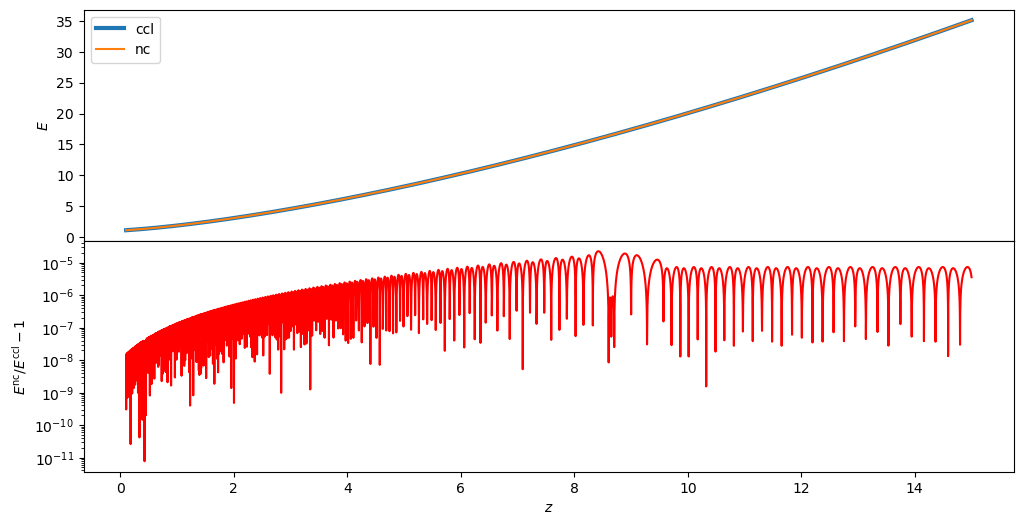

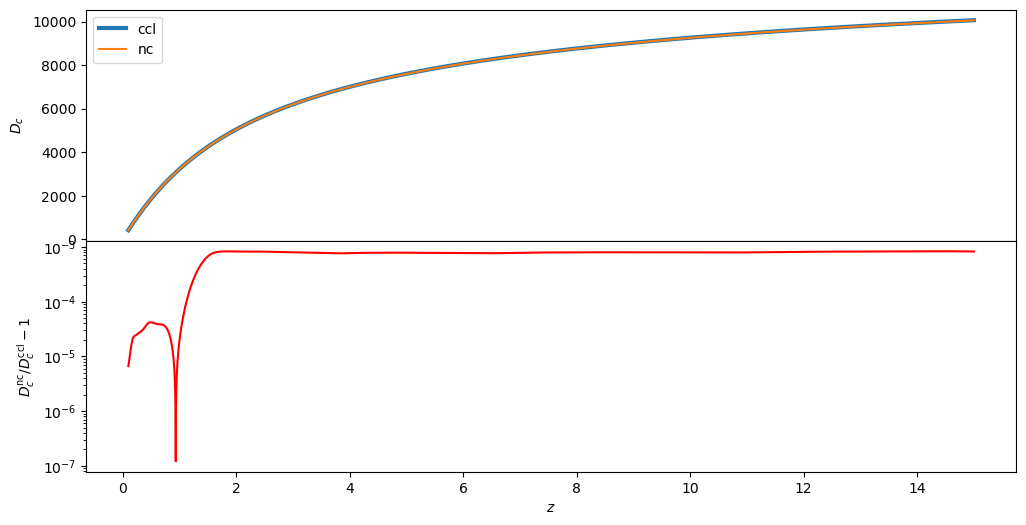

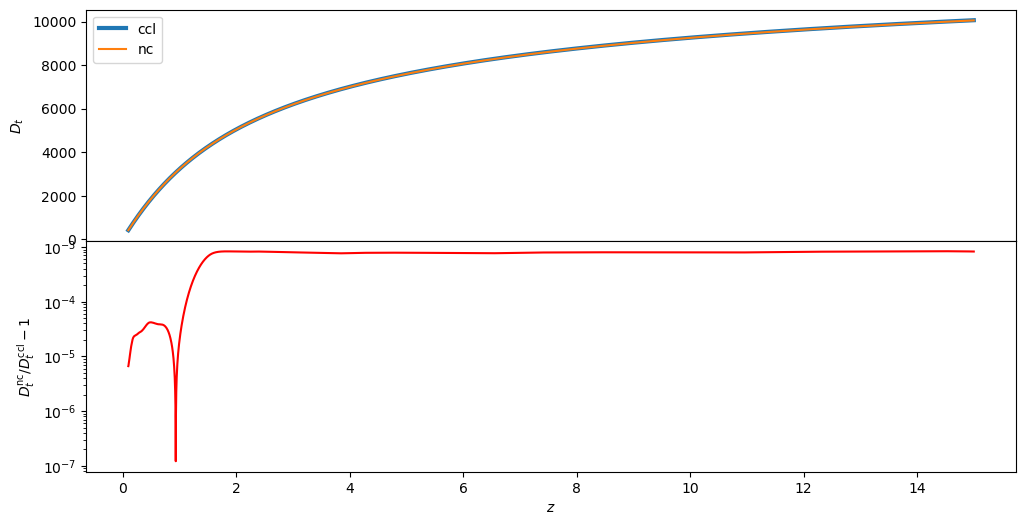

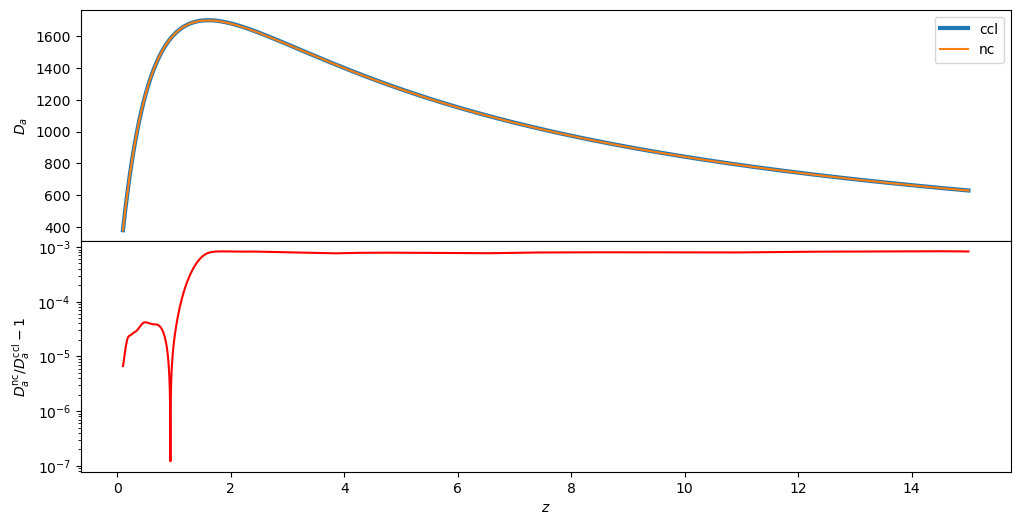

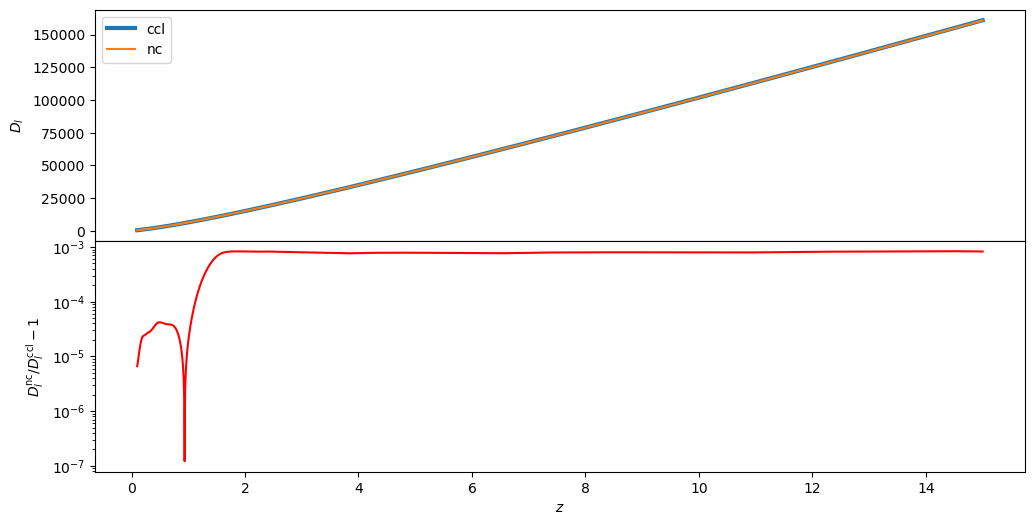

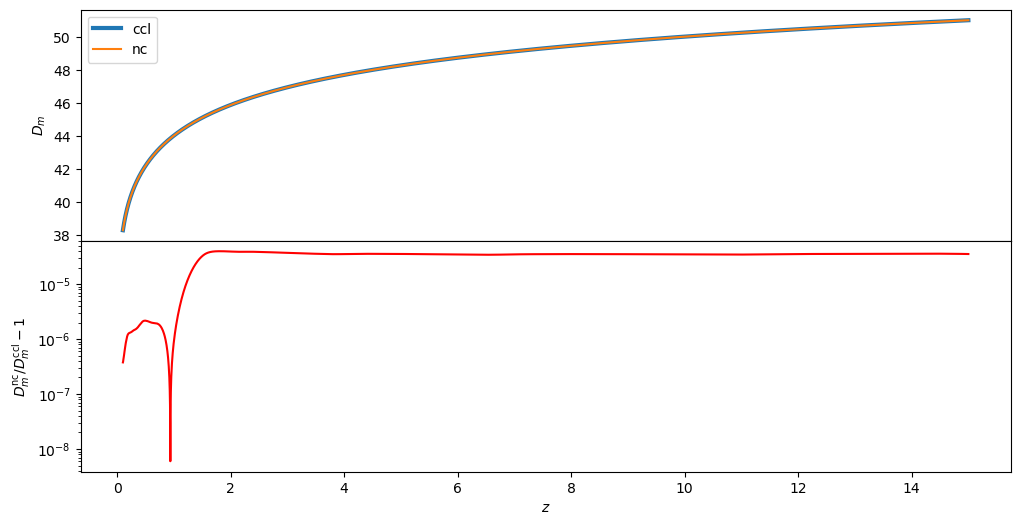

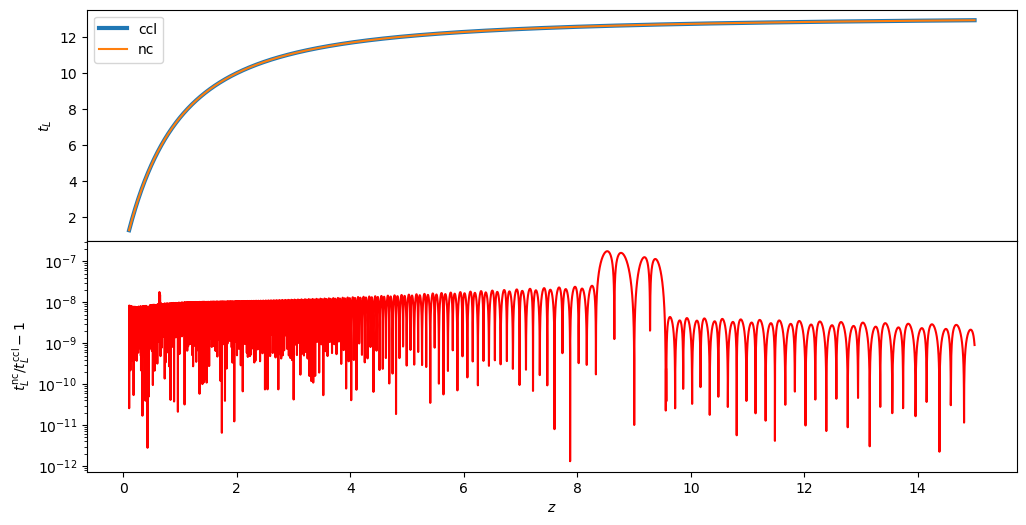

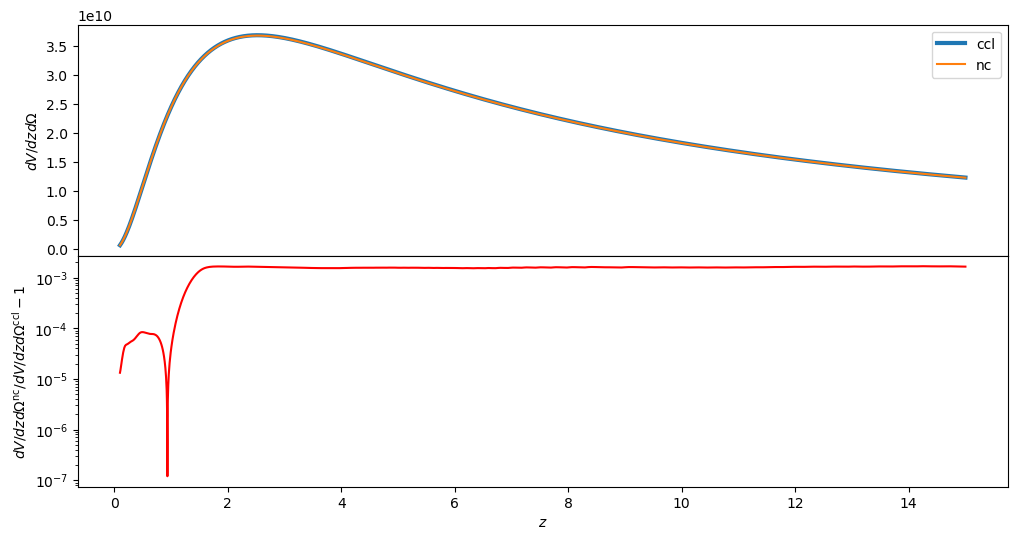


--------------------------------------------------------------------------------
[E         ]: rel diff min: 7.42850226e-13	rel diff max: 2.24045803e-05
[D_c       ]: rel diff min: 9.39050371e-08	rel diff max: 5.14807241e-04
[D_t       ]: rel diff min: 9.45139649e-08	rel diff max: 5.59860960e-04
[D_a       ]: rel diff min: 9.45139649e-08	rel diff max: 5.59860960e-04
[D_l       ]: rel diff min: 9.45139649e-08	rel diff max: 5.59860960e-04
[D_m       ]: rel diff min: 4.72801842e-09	rel diff max: 2.38118658e-05
[t_L       ]: rel diff min: 1.45683465e-12	rel diff max: 1.75192366e-07
[dV/dzd\Omega]: rel diff min: 9.88087194e-08	rel diff max: 1.12495525e-03
--------------------------------------------------------------------------------



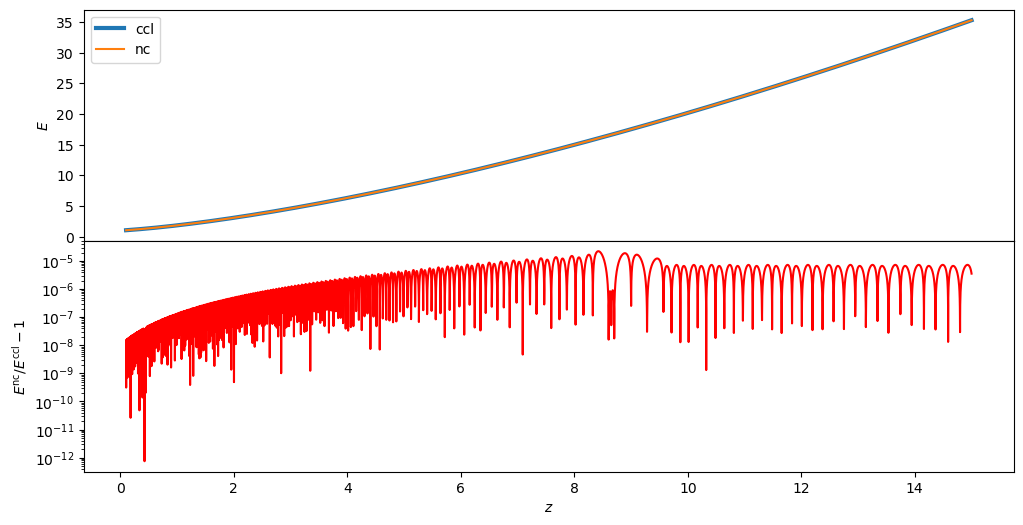

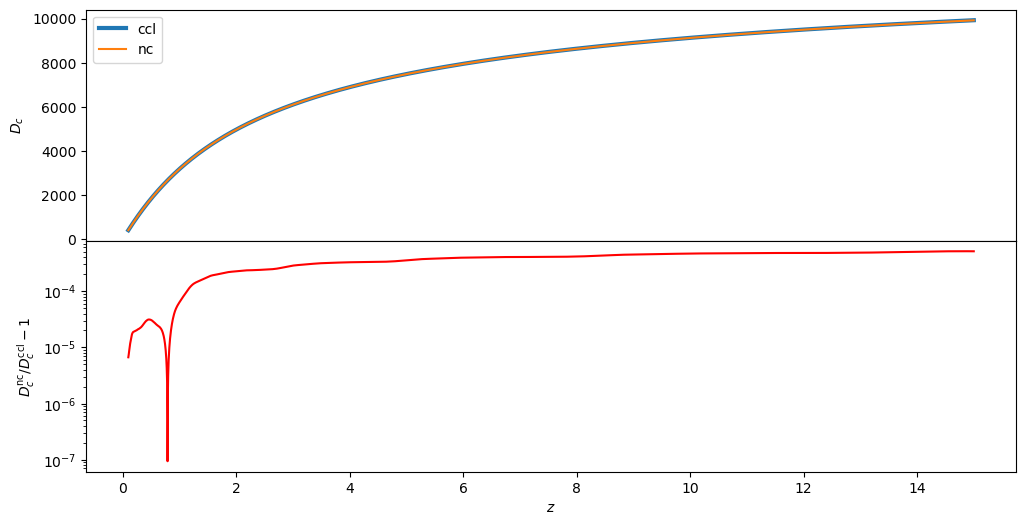

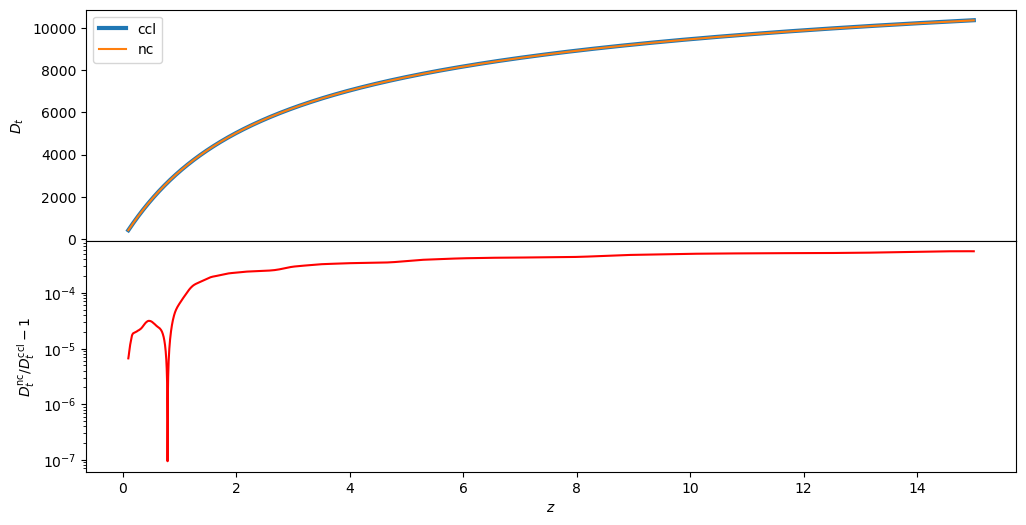

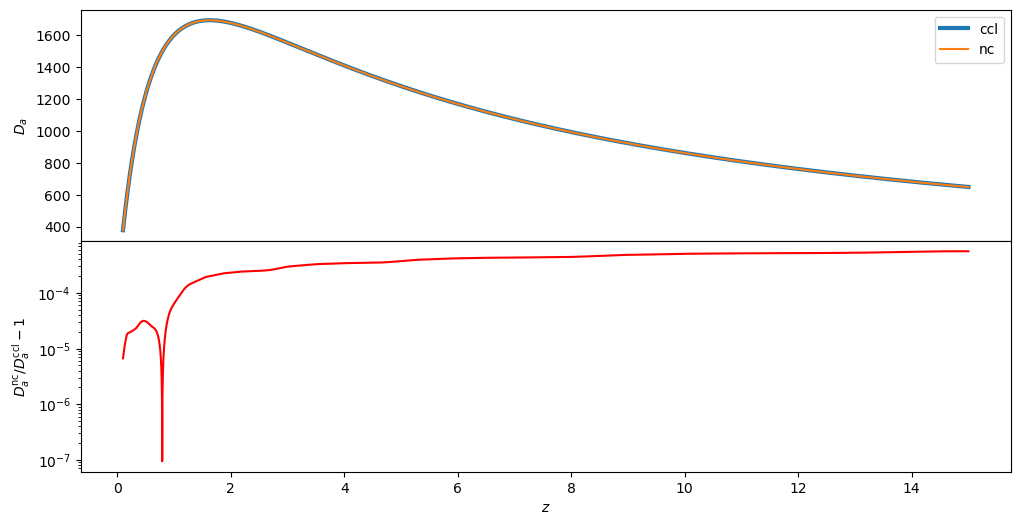

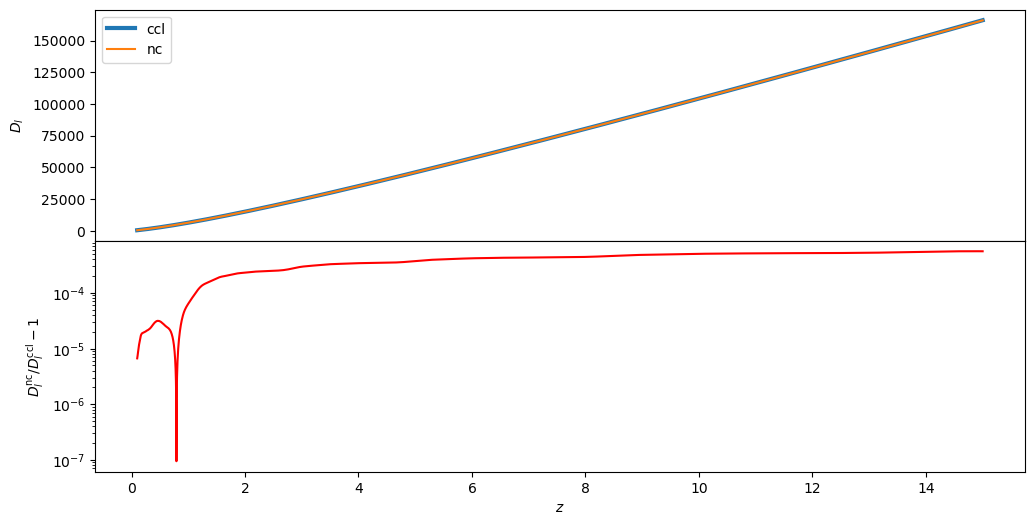

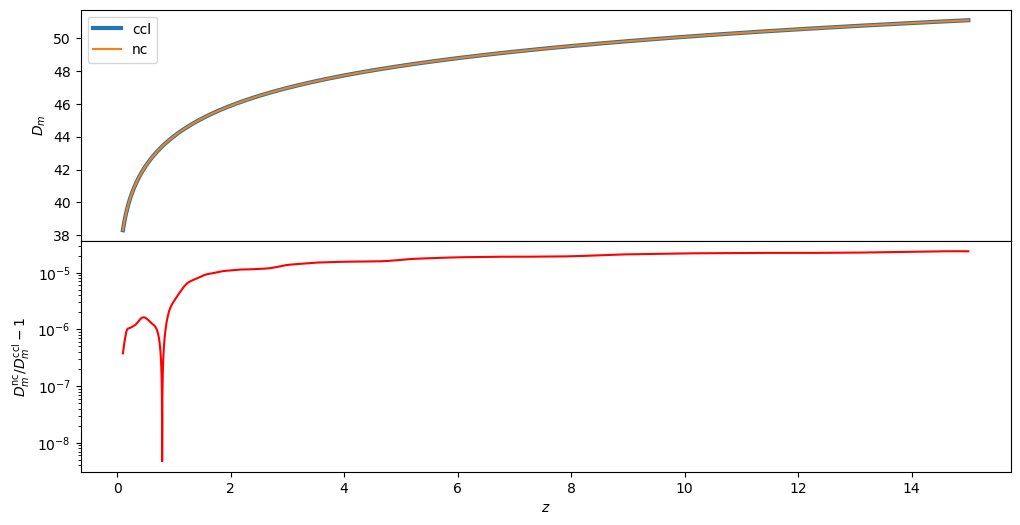

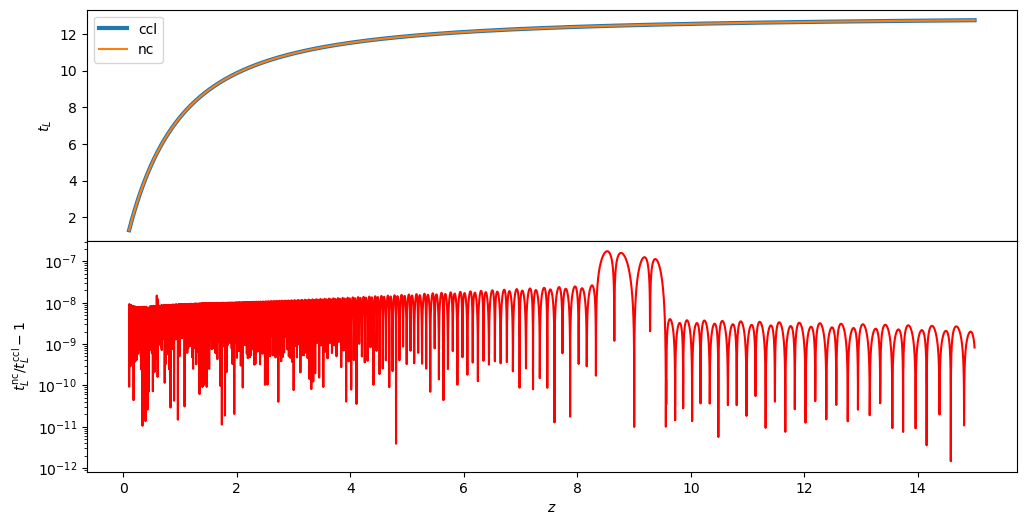

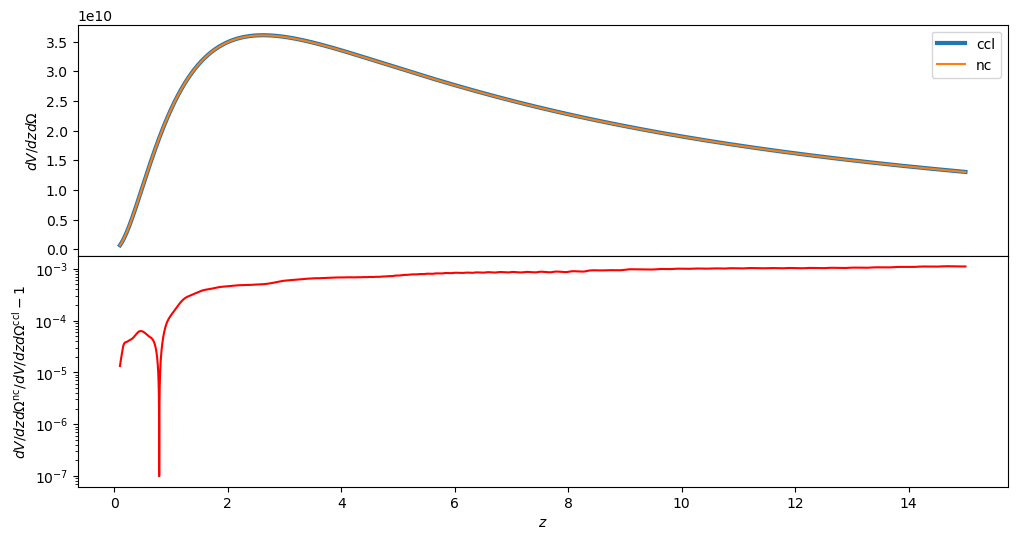


--------------------------------------------------------------------------------
[E         ]: rel diff min: 1.59950941e-11	rel diff max: 2.27197733e-05
[D_c       ]: rel diff min: 2.76464803e-07	rel diff max: 7.37401775e-04
[D_t       ]: rel diff min: 2.72476725e-07	rel diff max: 6.67149251e-04
[D_a       ]: rel diff min: 2.72476725e-07	rel diff max: 6.67149251e-04
[D_l       ]: rel diff min: 2.72476725e-07	rel diff max: 6.67149251e-04
[D_m       ]: rel diff min: 1.32026120e-08	rel diff max: 2.87766970e-05
[t_L       ]: rel diff min: 2.00062189e-13	rel diff max: 1.79763609e-07
[dV/dzd\Omega]: rel diff min: 3.62932728e-07	rel diff max: 1.33974111e-03
--------------------------------------------------------------------------------



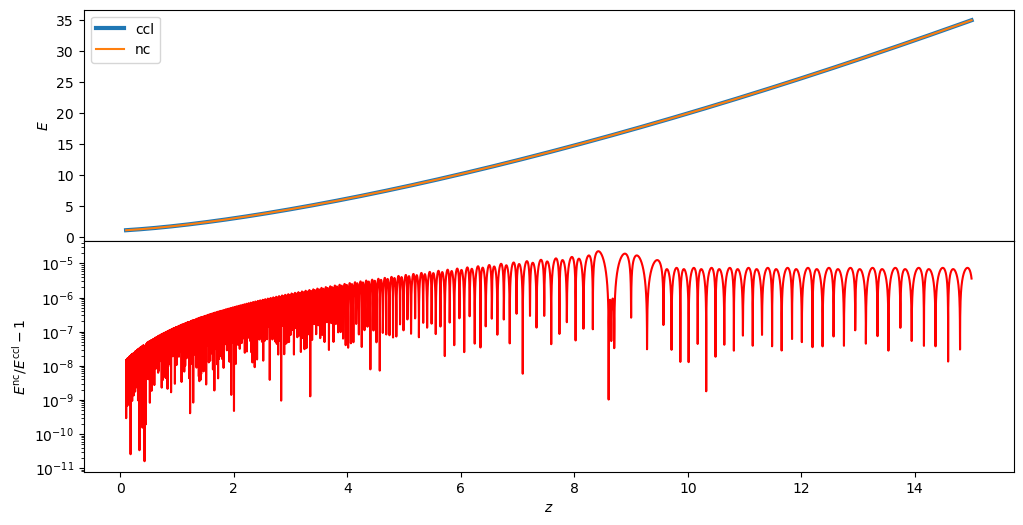

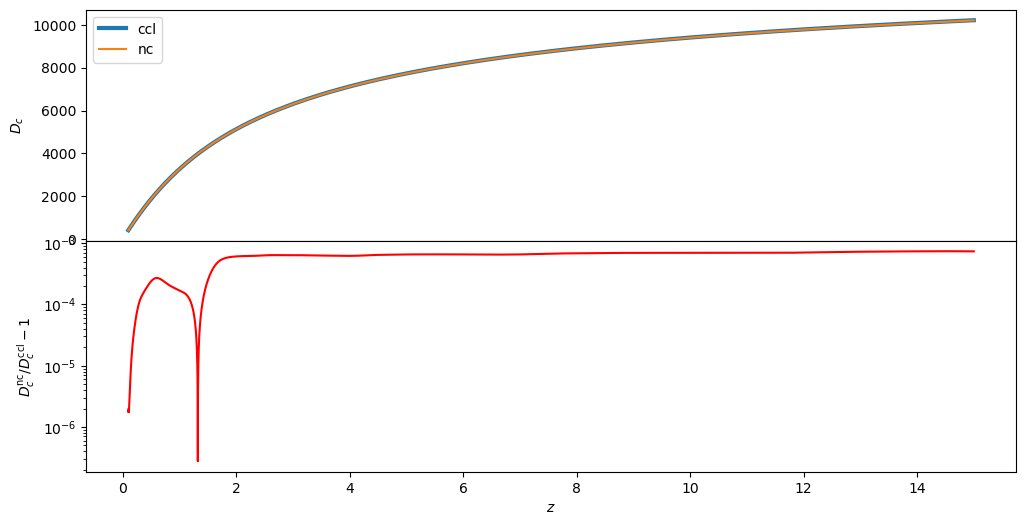

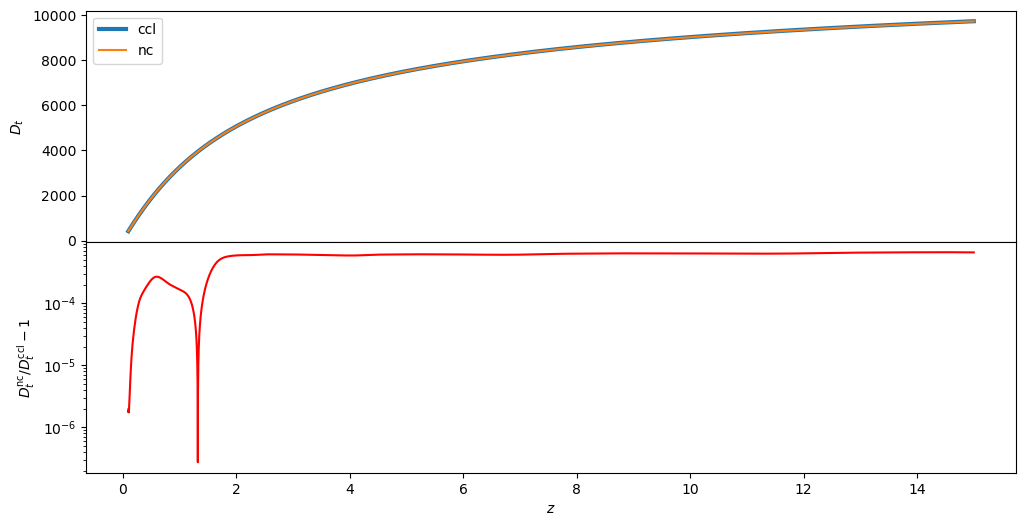

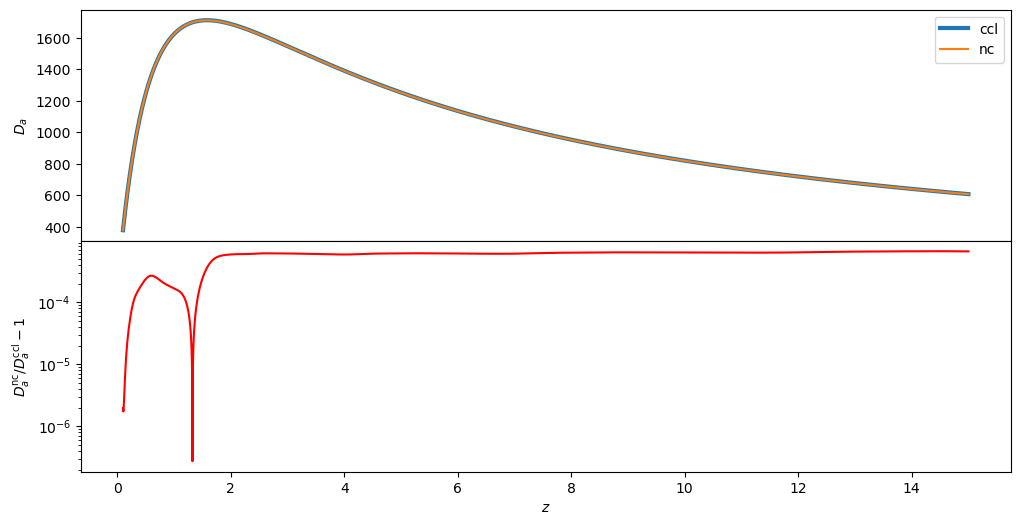

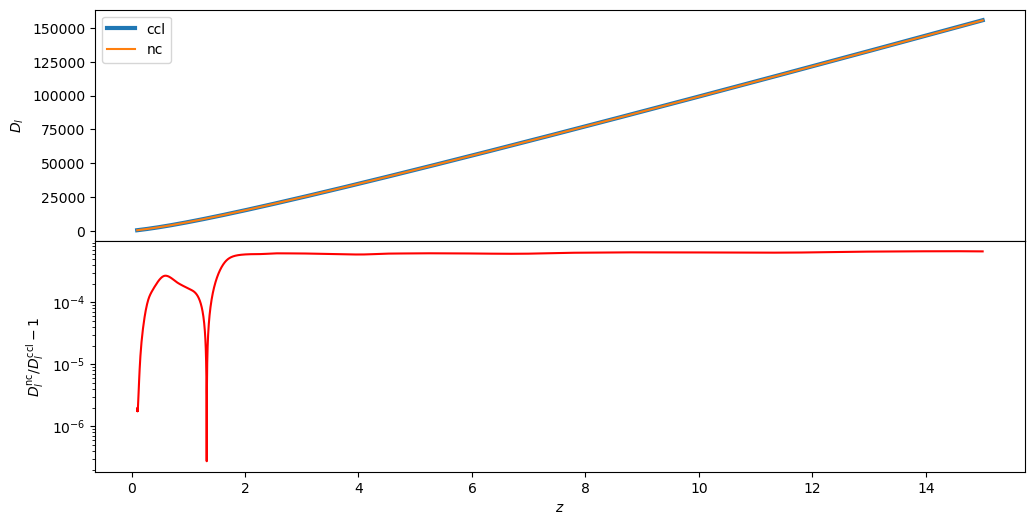

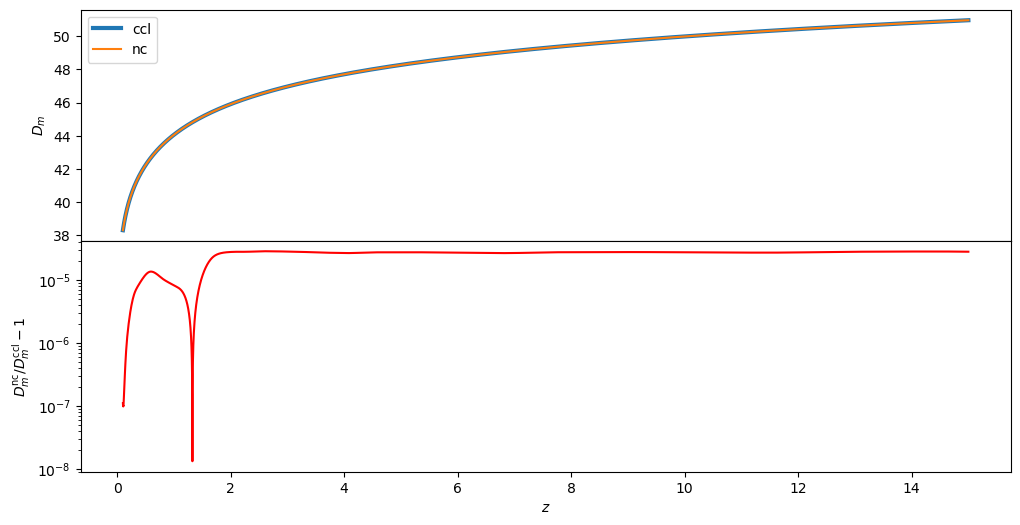

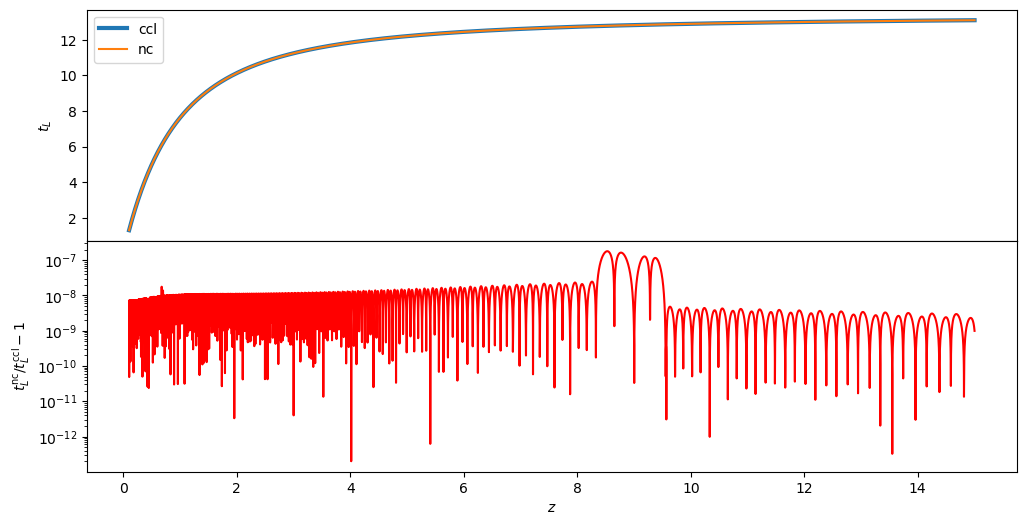

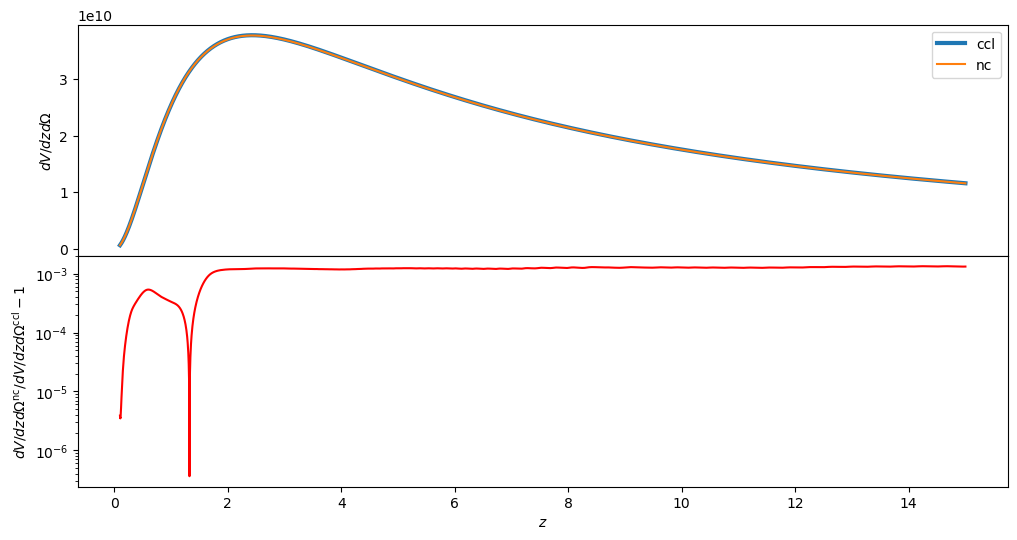

In [5]:
z = np.linspace(0.1, 15.0, 10000)

for i in range(5):
    print("-" * 80)
    compare_distances(z, Omega_v_vals[i], w0_vals[i], wa_vals[i])
    print("-" * 80 + "\n")

    plt.show()
    plt.close()  # It's faster to close figures in each loop
    print()

### 1.1) Time Comparison

We compare the time spent on calculating the cosmological distances. First, it is necessary to create again the cosmology used in the function, then we use "timeit" to estimate the mean time intervals it takes for each library to perform the calculations. Note that we are calling NumCosmo's functions in a list comprehension.

In [5]:
Omega_k = 1.0 - Omega_c - Omega_b - Omega_v_vals[0]

ccl_cosmo = ccl.Cosmology(
    Omega_c=Omega_c,
    Omega_b=Omega_b,
    Neff=Neff,
    h=h,
    A_s=A_s,
    n_s=n_s,
    Omega_k=Omega_k,
    w0=w0_vals[0],
    wa=wa_vals[0],
    transfer_function="eisenstein_hu",
)

CCLParams.set_high_prec_params()
cosmology = create_nc_obj(ccl_cosmo, dist_z_max=20.0)

cosmo = cosmology.cosmo
dist = cosmology.dist
z = np.linspace(0.1, 15.0, 100000)
a = 1.0 / (1.0 + z)

In [6]:
print("1.1.1) COMOVING DISTANCE\n")
%timeit ccl_chi = ccl.comoving_radial_distance(ccl_cosmo, a)
RH_Mpc  = cosmo.RH_Mpc ()
%timeit nc_chi  = dist.comoving_vector (cosmo, z)
print()

print("1.1.2) TRANSVERSE COMOVING DISTANCE\n")
%timeit ccl_ct = ccl.comoving_angular_distance(ccl_cosmo, a)
%timeit nc_ct  = dist.transverse_vector (cosmo, z)
print()

print("1.1.3) ANGULAR DIAMETER DISTANCE\n")
%timeit ccl_cad = ccl.angular_diameter_distance(ccl_cosmo, a)
%timeit nc_cad  = dist.angular_diameter_vector (cosmo, z)
print()

print("1.1.4) LUMINOSITY DISTANCE\n")
%timeit ccl_ld = ccl.luminosity_distance(ccl_cosmo, a)
%timeit nc_ld  = dist.luminosity_vector (cosmo, z)
print()

print("1.1.5) DISTANCE MODULUS\n")
%timeit ccl_dm = ccl.distance_modulus(ccl_cosmo, a)
%timeit nc_dm  = [dist.dmodulus (cosmo, z_i) + 5*math.log10(RH_Mpc) for z_i in z]
print()

1.1.1) COMOVING DISTANCE

1.62 ms ± 22.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
8.67 ms ± 542 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

1.1.2) TRANSVERSE COMOVING DISTANCE

1.75 ms ± 22.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
8.91 ms ± 413 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

1.1.3) ANGULAR DIAMETER DISTANCE

3.83 ms ± 728 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.61 ms ± 539 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

1.1.4) LUMINOSITY DISTANCE

1.84 ms ± 21.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
8.72 ms ± 424 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

1.1.5) DISTANCE MODULUS

2.69 ms ± 290 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
62.6 ms ± 4.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)



### 2) Growth

The next function will compare the growth factor and growth rate of the CCL cosmology and the NumCosmo cosmology.

"CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!"
 \-  CCL Cosmology.compute_growth()

In [ ]:
def compare_growth(z, Omega_v, w0, wa):
    """
    Compare the growth function 'D' and the growth rate 'f' calculated by pyccl
    with the values obtained with NumCosmo.
    This test is only valid when massive neutrinos is set to zero (ccl default parameter: mnu = 0.0).
    """

    # Set Omega_K in a consistent way
    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ccl_cosmo = ccl.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        Neff=Neff,
        h=h,
        A_s=A_s,
        n_s=n_s,
        Omega_k=Omega_k,
        w0=w0,
        wa=wa,
        transfer_function="eisenstein_hu",
    )

    CCLParams.set_high_prec_params()
    cosmo, dist, ps_lin, ps_nln, hmfunc = create_nc_obj(ccl_cosmo)

    gf = ps_lin.peek_gf()
    gf.prepare(cosmo)

    a = 1.0 / (1.0 + z)

    nc_D_z = [gf.eval(cosmo, z_i) for z_i in z]
    ccl_D_z = ccl.growth_factor(ccl_cosmo, a)

    compare_ccl_nc_func(z, ccl_D_z, nc_D_z, x_name="z", y_name="D", xscale="linear")

    nc_f_z = [
        -(1.0 + z_i) / gf.eval(cosmo, z_i) * gf.eval_deriv(cosmo, z_i) for z_i in z
    ]
    ccl_f_z = ccl.growth_rate(ccl_cosmo, a)

    compare_ccl_nc_func(z, ccl_f_z, nc_f_z, x_name="z", y_name="f", xscale="linear")

    ccl.gsl_params.reload()
    ccl.spline_params.reload()

In [ ]:
z = np.linspace(0.0, 5.0, 10000)

for i in range(5):
    print("-" * 80)
    compare_growth(z, Omega_v_vals[i], w0_vals[i], wa_vals[i])
    print("-" * 80 + "\n")

plt.show()
plt.close()
print()

### 2.1) Time Comparison

We compare the time spent on calculating the growth factor and the growth rate.

<!-- #### 2.1.1) Growth Factor -->

In [ ]:
# a = 1. / (1. + z)
# %timeit ccl_D_z = ccl.growth_factor (ccl_cosmo, a)

# %%timeit

# gf = ps_lin.peek_gf ()
# gf.prepare (cosmo)
# nc_D_z = [gf.eval (cosmo, z_i) for z_i in z]

#### 2.1.2) Growth Rate

In [ ]:
# a = 1. / (1. + z)
# %timeit ccl_f_z = ccl.growth_rate (ccl_cosmo, a)

# %%timeit

# gf = ps_lin.peek_gf ()
# gf.prepare (cosmo)
# nc_f_z = [-(1.0 + z_i) / gf.eval (cosmo, z_i) * gf.eval_deriv (cosmo, z_i) for z_i in z]

### 3) Cosmology Parameters

The next function will compare the the total mass density (barionic + cold dark matter + massive neutrinos), the total mass density parameter, and the normalized Hubble function.

In [ ]:
def compare_parameters(z, Omega_v, w0, wa):
    """
    Compare some parameters as functions of redshift.
    """

    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ccl_cosmo = ccl.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        Neff=Neff,
        h=h,
        A_s=A_s,
        n_s=n_s,
        Omega_k=Omega_k,
        w0=w0,
        wa=wa,
        transfer_function="eisenstein_hu",
    )

    CCLParams.set_high_prec_params()
    cosmo, dist, ps_lin, ps_nln, hmfunc = create_nc_obj(ccl_cosmo)

    a = 1.0 / (1.0 + z)

    ccl_Om = ccl.omega_x(ccl_cosmo, a, "matter")
    nc_Om = [cosmo.E2Omega_m(z_i) / cosmo.E2(z_i) for z_i in z]

    compare_ccl_nc_func(z, ccl_Om, nc_Om, x_name="z", y_name=r"\Omega_m")

    ccl_Og = ccl.omega_x(ccl_cosmo, a, "radiation")
    nc_Og = [cosmo.E2Omega_g(z_i) / cosmo.E2(z_i) for z_i in z]

    compare_ccl_nc_func(z, ccl_Og, nc_Og, x_name="z", y_name=r"\Omega_g")

    ccl_dens = ccl.rho_x(ccl_cosmo, a, "matter")
    const = Ncm.C.Mpc() ** 3 / (Ncm.C.mass_solar() * Ncm.C.c() ** 2)
    nc_dens = [cosmo.E2Omega_m(z_i) * cosmo.crit_density() * const for z_i in z]

    compare_ccl_nc_func(z, ccl_dens, nc_dens, x_name="z", y_name=r" \rho_m")

    ccl_dens_g = ccl.rho_x(ccl_cosmo, a, "radiation")
    const = Ncm.C.Mpc() ** 3 / (Ncm.C.mass_solar() * Ncm.C.c() ** 2)
    nc_dens_g = [cosmo.E2Omega_g(z_i) * cosmo.crit_density() * const for z_i in z]

    compare_ccl_nc_func(z, ccl_dens_g, nc_dens_g, x_name="z", y_name=r" \rho_g")

    ccl.gsl_params.reload()
    ccl.spline_params.reload()

In [ ]:
z = np.linspace(0.1, 15.0, 10000)

for i in range(5):
    print("-" * 80)
    compare_parameters(z, Omega_v_vals[i], w0_vals[i], wa_vals[i])
    print("-" * 80 + "\n")

    plt.show()
    plt.close()
    print()

In [ ]:
# print("5.1.1) MATTER DENSITY PARAMETER\n")
# %timeit ccl_Og = ccl.omega_x (ccl_cosmo, a, 'matter')
# %timeit nc_0g = [cosmo.E2Omega_m (z_i) / cosmo.E2 (z_i) for z_i in z]
# print()

# print("5.1.2) NORM. HUBBLE FUNCTION\n")
# %timeit ccl_E = ccl.h_over_h0 (ccl_cosmo, a)
# %timeit nc_E  = [cosmo.E (z_i) for z_i in z]
# print()

# print("5.1.3) MATTER DENSITY\n")
# const = Ncm.C.Mpc()**3 / (Ncm.C.mass_solar()*Ncm.C.c()**2 )
# %timeit ccl_dens = ccl.rho_x(ccl_cosmo, a, 'matter')
# %timeit nc_dens  = [cosmo.E2Omega_m (z_i)*cosmo.crit_density()*const for z_i in z]
# print()

### 4) Scale Factor

The next function will compare the scale factor calculated from a comoving distance ξ (in Megaparsecs).

In [ ]:
def compare_scaleFactor(chi, Omega_v, w0, wa):
    """
    Compare the scale factor at distance 'chi'(Mpc).
    """

    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ccl_cosmo = ccl.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        Neff=Neff,
        h=h,
        A_s=A_s,
        n_s=n_s,
        Omega_k=Omega_k,
        w0=w0,
        wa=wa,
        transfer_function="eisenstein_hu",
    )

    CCLParams.set_high_prec_params()
    cosmo, dist, ps_lin, ps_nln, hmfunc = create_nc_obj(ccl_cosmo)

    dist.compute_inv_comoving(True)
    dist.prepare(cosmo)

    RH_Mpc = cosmo.RH_Mpc()

    ccl_a = ccl.scale_factor_of_chi(ccl_cosmo, chi)
    nc_a = [1 / (1 + dist.inv_comoving(cosmo, d / RH_Mpc)) for d in chi]

    compare_ccl_nc_func(chi, ccl_a, nc_a, x_name="D_c", y_name="a")

    ccl.gsl_params.reload()
    ccl.spline_params.reload()

In [ ]:
chi = np.geomspace(1, 1e4, 1000)

print("-" * 80)
compare_scaleFactor(chi, 0.7, -1.0, 0.0)
print("-" * 80 + "\n")

plt.show()
plt.close()
print()

In [ ]:
# print("4.1.1) SCALE FACTOR\n")
# chi = np.geomspace(1, 1e4, 1000)
# RH_Mpc = cosmo.RH_Mpc ()
# dist.compute_inv_comoving (True)
# dist.prepare (cosmo)
# %timeit ccl_a = ccl.scale_factor_of_chi(ccl_cosmo, chi)
# %timeit nc_a  = [1/ (1+ dist.inv_comoving(cosmo, d/RH_Mpc)) for d in chi]
# print()

### 5) Sigma Critical

The next function will compare the critical surface mass density.

In [ ]:
def compare_sigmaC(zs, zl, Omega_v, w0, wa):
    """
    Compare the critical surface density for multiple values of source redshift, given a fixed lens redshift
    """

    # Set Omega_K in a consistent way
    Omega_k = 1.0 - Omega_c - Omega_b - Omega_v

    ccl_cosmo = ccl.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        Neff=Neff,
        h=h,
        sigma8=sigma8,
        n_s=n_s,
        Omega_k=Omega_k,
        w0=w0,
        wa=wa,
        transfer_function="eisenstein_hu",
    )

    CCLParams.set_high_prec_params()
    cosmo, dist, ps_lin, ps_nln, hmfunc = create_nc_obj(ccl_cosmo)

    a_s = 1.0 / (1.0 + zs)
    a_l = 1.0 / (1.0 + zl)

    sigmaC_ccl = ccl.sigma_critical(ccl_cosmo, a_lens=a_l, a_source=a_s)
    sigmaC_nc = [dist.sigma_critical(cosmo, zsi, zl) for zsi in zs]

    compare_ccl_nc_func(zs, sigmaC_ccl, sigmaC_nc, x_name="z_s", y_name="\\Sigma_c")

In [ ]:
zs = z = np.linspace(1, 5.0, 10000)
zl = 0.5

for i in range(5):
    print("-" * 80)
    compare_sigmaC(zs, zl, Omega_v_vals[i], w0_vals[i], wa_vals[i])
    print("-" * 80 + "\n")

plt.show()
plt.close()
print()

### Summary

The table below show all estimated times and orders of the minimum and maximum relative differences for each function compared in this notebook. The CCL function for the unnormalized growth factor is not being compared, since NumCosmo does not have a specific function to compute it.



<table {style="border-style: solid;"}>
  <tr>
    <th>Function</th>
    <th>Runtime CCL</th>
    <th>Runtime NumCosmo</th>
    <th>Min. Rel. Diff. Order</th>
    <th>Max. Rel. Diff. Order</th>
    <tr>
  <tr>
    <td>Norm. Hubble Function</td>
    <td>(424 ± 11) μs</td>
    <td>(6.49 ± 0.97) ms</td>
    <td>1e-12</td>
      <td>1e-05</td>
  </tr>
  <tr>
      <td>Comoving Distance</td>
      <td>(288 ± 3) μs</td>
      <td>(6.72 ± 0.83) ms</td>
      <td>1e-12</td>
      <td>1e-08</td>
  </tr>
  <tr>
      <td>Transverse Comoving Distance</td>
      <td>(312 ± 2) μs</td>
      <td>(7.58 ± 0.14) ms</td>
      <td>1e-12</td>
      <td>1e-08</td>
  </tr>
  <tr>
      <td>Angular Diameter Distance</td>
      <td>(605 ± 3) μs</td>
      <td>(7.52 ± 0.03) ms</td>
      <td>1e-12</td>
      <td>1e-08</td>
  </tr>
  <tr>
      <td>Luminosity Distance</td>
      <td>(325 ± 2) μs</td>
      <td>(7.58 ± 0.16) ms</td>
      <td>1e-12</td>
      <td>1e-08</td>
  </tr>
  <tr>
      <td>Distance Modulus</td>
      <td>(576 ± 6) μs</td>
      <td>(9.29 ± 0.92) ms</td>
      <td>1e-13</td>
      <td>1e-08</td>
  </tr>
  <tr>
      <td>Lookbacktime</td>
      <td>(576 ± 6) μs</td>
      <td>(9.29 ± 0.92) ms</td>
      <td>1e-11</td>
      <td>1e-07</td>
  </tr>    
  <tr>
      <td>Comoving volume element</td>
      <td>(576 ± 6) μs</td>
      <td>(9.29 ± 0.92) ms</td>
      <td>1e-11</td>
      <td>1e-05</td>
  </tr>    
  <tr>
      <td>Growth Factor</td>
      <td>(300 ± 19) μs</td>
      <td>(8.45 ± 0.11) ms</td>
      <td>1e-13</td>
      <td>1e-08</td>
  </tr>
  <tr>
      <td>Growth Rate</td>
      <td>(299 ± 2) μs</td>
      <td>(16.7 ± 0.11) ms</td>
      <td>1e-10</td>
      <td>1e-08</td>
  </tr>
  <tr>
    <td>Matter Density Parameter</td>
    <td>(493 ± 7) μs</td>
     <td>(12.3 ± 0.1) ms</td>
     <td>1e-10</td>
      <td>1e-08</td>
  </tr>
  <tr>
    <td>Matter Density</td>
    <td>(909 ± 3) μs</td>
    <td>(10.8 ± 0.86) ms</td>
    <td>1e-16</td>
      <td>1e-15</td>
  </tr>
   <tr>
      <td>Scale Factor</td>
      <td>(36.8 ± 0.1) μs</td>
      <td>(800 ± 8.45) μs</td>
      <td>1e-13</td>
      <td>1e-08</td>
  </tr>
  <tr>
      <td>Sigma Critical</td>
      <td>(1.150 ± 0.003) ms</td>
      <td>(10.4 ± 0.81) ms</td>
      <td>1e-09</td>
      <td>1e-09</td>
  </tr>
</table>